In [83]:
import pingouin as pg
import matplotlib.pyplot as plt
import os
import h5py
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [84]:
# Age
age = [22, 23, 23, 22, 22, 23, 23, 23, 21, 22, 23, 21, 18, 23, 20, 24, 21, 37, 40, 43]
print('mean =', np.average(age))
print('std =', np.std(age))

mean = 24.7
std = 6.626462102811726


In [85]:
# define style for figures
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("talk")


In [86]:
# Get the current directory where the script is running
current_directory = os.getcwd()

# Get a list of all the participant folders (assuming they are all in the same directory)
participants_folders = sorted([f for f in os.listdir(current_directory) if os.path.isdir(f)])

# Initialize an empty list to store data
data = []

SN = 0  # Subject Number counter

# Loop through each participant folder
for folder in participants_folders:
    SN += 1  # Increment Subject Number
    file_path = os.path.join(current_directory, folder, "all_trials.csv")  # Path to all_trials.csv
    
    if os.path.isfile(file_path):  # Check if the file exists
        data_temp = pd.read_csv(file_path)  # Read the CSV file

        # Insert the Subject Number (SN) as the first column
        data_temp.insert(0, "SN", SN)

        # Append to the list of data
        data.append(data_temp)

# Merge all data into a single DataFrame
merged_df = pd.concat(data, ignore_index=True)

# Print the merged DataFrame (optional)
print(merged_df)

# Save to a new CSV file
merged_df.to_csv("merged_all_trials.csv", index=False)

      SN  assistance  block  trial  emg     score  score_feedback  rate
0      1        0.00      1      0    1  0.405413        0.405413     3
1      1        0.50      1      1    1  0.219117        0.609558     1
2      1        0.10      1      2    1  0.310939        0.379845     3
3      1        0.25      1      3    1 -0.234162        0.074379     3
4      1        0.25      1      4    1  0.098003        0.323502     6
...   ..         ...    ...    ...  ...       ...             ...   ...
2395  20        0.10      6     15    1  0.240152        0.316137     6
2396  20        0.00      6     16    1  0.445145        0.445145     7
2397  20        0.10      6     17    1  0.436270        0.492643     7
2398  20        0.25      6     18    1  0.124769        0.343577     7
2399  20        0.50      6     19    1  0.073693        0.536846     7

[2400 rows x 8 columns]


In [87]:
# Drop column 'trial and emg'
merged_df = merged_df.drop('trial', axis=1)
merged_df = merged_df.drop('emg', axis=1)

# Renaming columns
merged_df.rename(columns={'rate': 'SoA'}, inplace=True)
print(merged_df)


      SN  assistance  block     score  score_feedback  SoA
0      1        0.00      1  0.405413        0.405413    3
1      1        0.50      1  0.219117        0.609558    1
2      1        0.10      1  0.310939        0.379845    3
3      1        0.25      1 -0.234162        0.074379    3
4      1        0.25      1  0.098003        0.323502    6
...   ..         ...    ...       ...             ...  ...
2395  20        0.10      6  0.240152        0.316137    6
2396  20        0.00      6  0.445145        0.445145    7
2397  20        0.10      6  0.436270        0.492643    7
2398  20        0.25      6  0.124769        0.343577    7
2399  20        0.50      6  0.073693        0.536846    7

[2400 rows x 6 columns]


### SoA vs SN 

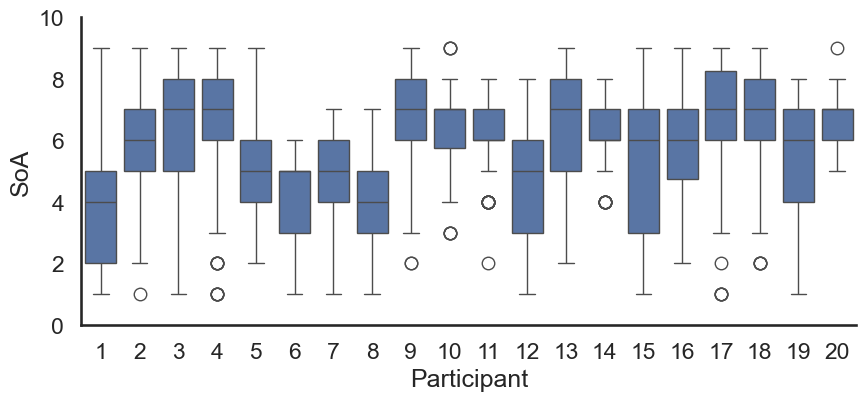

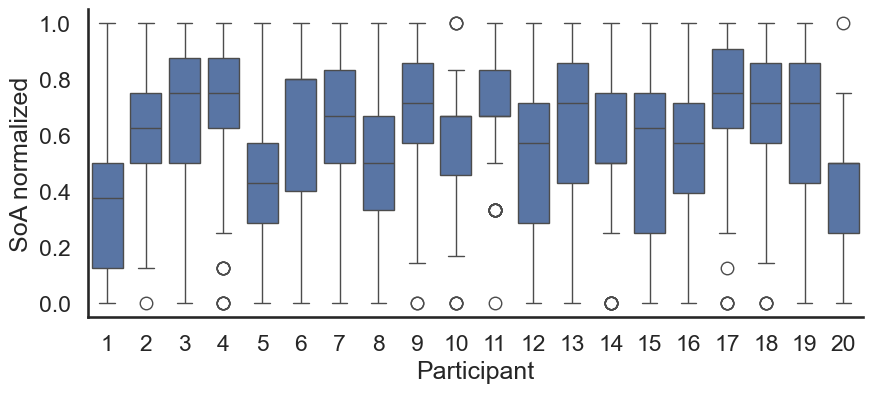

In [88]:
import matplotlib.pyplot as plt

# plot SoA vs SN 
plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=merged_df, x='SN', y='SoA')
ax.set_xlabel('Participant')
ax.set_ylabel('SoA')
ax.set(ylim=(0, 10))

sns.despine()
plt.show()

# Apply Min-Max scaling within each SN group
merged_df["SoA_normalized"] = merged_df.groupby("SN")["SoA"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# plot SoA vs SN normalized
plt.figure(figsize=(10, 4))
ax = sns.boxplot(data=merged_df, x='SN', y='SoA_normalized')
ax.set_xlabel('Participant')
ax.set_ylabel('SoA normalized')

sns.despine()
plt.show()

In [89]:
pg.anova(data=merged_df, dv='SoA', between='SN', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,SN,2069.398333,19,108.915702,38.361572,4.628090e-123,0.234448
1,Within,6757.266667,2380,2.839188,NaN,NaN,NaN


#### Results
Statistically Significant: The SN factor has a statistically significant effect on SoA (p-value < 0.05).

Large Effect Size: The effect size is large (23%), indicating that SN explains a substantial portion of the variance in SoA.

### Score feedback vs Score when Assistance = 0.0

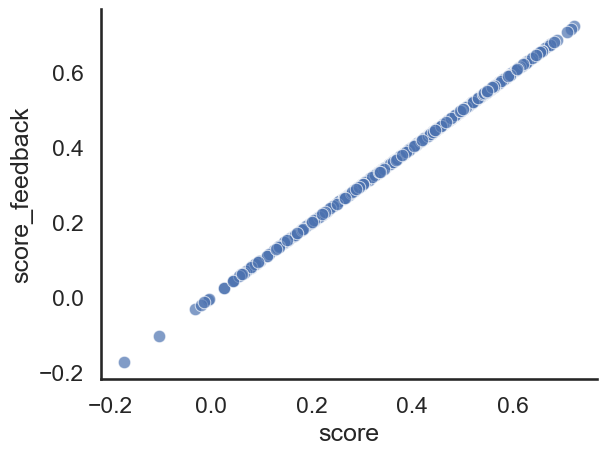

In [107]:
# Filter the dataframe to include only rows where assistance = 0.0
df_filtered = merged_df[merged_df['assistance'] == 0.0]

# Create scatter plot
sns.scatterplot(x=df_filtered["score"], y=df_filtered["score_feedback"], alpha=0.7)
sns.despine()

## Averaged to have 1 input for each assistance level in each block, per participant

In [91]:
# Average them to have 1 input for each assistance level in each block
df_grouped = merged_df.groupby(['SN', 'block', 'assistance']).mean().reset_index()

# Display the new dataframe
print(df_grouped)

     SN  block  assistance     score  score_feedback  SoA  SoA_normalized
0     1      1        0.00  0.439978        0.439978  5.0           0.500
1     1      1        0.10  0.316674        0.385006  4.4           0.425
2     1      1        0.25  0.141992        0.356494  4.6           0.450
3     1      1        0.50 -0.012935        0.493532  2.0           0.125
4     1      2        0.00  0.543683        0.543683  5.8           0.600
..   ..    ...         ...       ...             ...  ...             ...
475  20      5        0.50  0.384159        0.692080  6.0           0.250
476  20      6        0.00  0.386389        0.386389  6.8           0.450
477  20      6        0.10  0.387112        0.448401  6.6           0.400
478  20      6        0.25  0.365720        0.524290  6.8           0.450
479  20      6        0.50  0.280571        0.640286  5.6           0.150

[480 rows x 7 columns]


## Plots grouped

aprenantatge continuu: regresiio de SoA per numero de trial controlant per assis

C:\Users\merin\AppData\Local\Temp\ipykernel_27788\3082051150.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_grouped, x='block', y='SoA', palette="Blues")


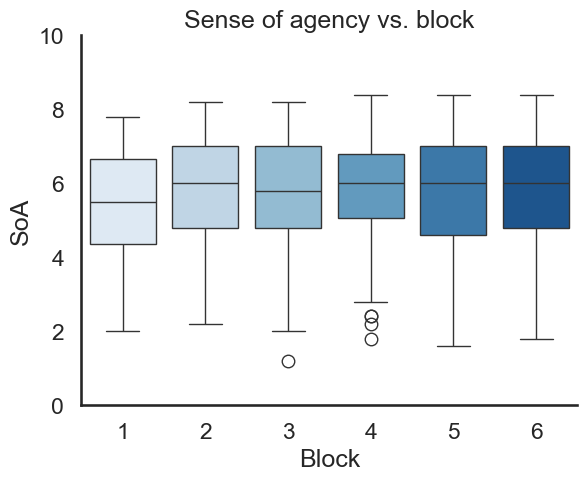

In [92]:
# plot SoA vs Block to see a trend
plt = sns.boxplot(data=df_grouped, x='block', y='SoA', palette="Blues")
plt.set_title('Sense of agency vs. block')
plt.set_xlabel('Block')
plt.set_ylabel('SoA')
plt.set(ylim=(0,10))

sns.despine()

C:\Users\merin\AppData\Local\Temp\ipykernel_27788\1623964704.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_grouped, x='assistance', y='SoA', palette="Blues")
C:\Users\merin\AppData\Local\Temp\ipykernel_27788\1623964704.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


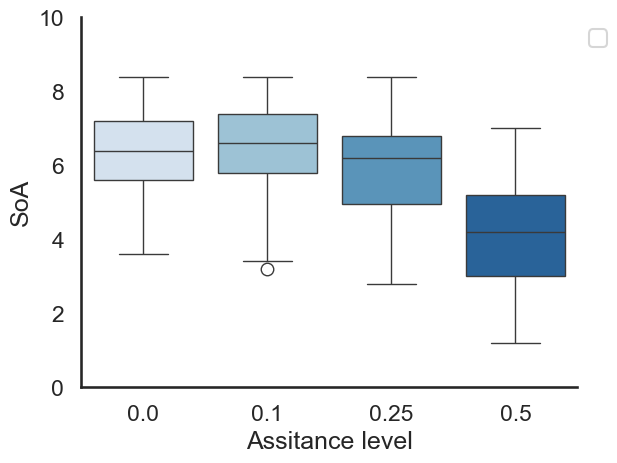

In [93]:
# plot SoA vs Assistance
plt = sns.boxplot(data=df_grouped, x='assistance', y='SoA', palette="Blues")
plt.set_xlabel('Assitance level')
plt.set_ylabel('SoA')
plt.set(ylim=(0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

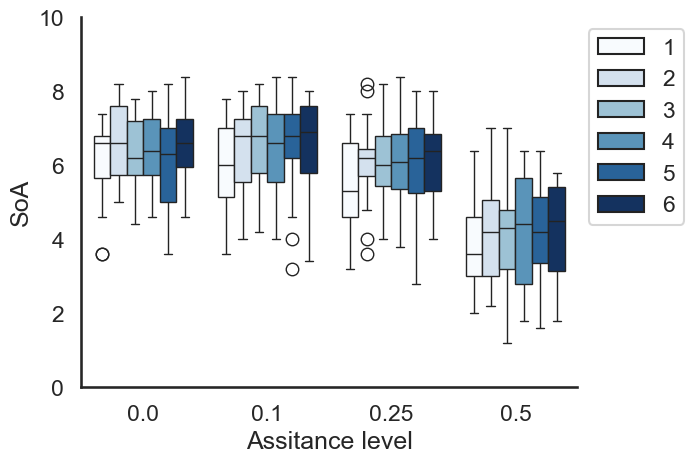

In [94]:
# plot SoA vs Assistance
plt = sns.boxplot(data=df_grouped, x='assistance', y='SoA', hue='block', palette="Blues")
plt.set_xlabel('Assitance level')
plt.set_ylabel('SoA')
plt.set(ylim=(0,10))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

## 2-way ANOVA

In [95]:
# two-way anova
model = ols('SoA ~ C(block) + C(assistance) + C(block):C(assistance)', data=df_grouped).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(block),14.842,5.0,1.883995,9.572998e-02
C(assistance),430.235,3.0,91.021061,3.580845e-46
C(block):C(assistance),5.148,15.0,0.217823,9.992752e-01
Residual,718.468,456.0,NaN,NaN


### 2-way anova results
statistical difference for Assistance and block, no interaction effect.
We can look at each separately and do a post-hoc test

## Group by assistance

In [96]:
# Group by assistance level. One assistance level for each subject
df_assis = df_grouped.groupby(['SN', 'assistance']).mean().reset_index()

# Erase block column
df_assis = df_assis.drop('block', axis=1)

# Display the new dataframe
print(df_assis)

    SN  assistance     score  score_feedback       SoA  SoA_normalized
0    1        0.00  0.317041        0.317041  4.833333        0.479167
1    1        0.10  0.322473        0.390226  4.066667        0.383333
2    1        0.25  0.243161        0.432371  4.233333        0.404167
3    1        0.50  0.025323        0.512661  2.233333        0.154167
4    2        0.00  0.373474        0.373474  5.766667        0.595833
..  ..         ...       ...             ...       ...             ...
75  19        0.50  0.204255        0.602127  3.800000        0.400000
76  20        0.00  0.452563        0.452563  7.200000        0.550000
77  20        0.10  0.437626        0.493864  7.166667        0.541667
78  20        0.25  0.397367        0.548026  6.866667        0.466667
79  20        0.50  0.328690        0.664345  6.366667        0.341667

[80 rows x 6 columns]


In [97]:
# statistics on SoA between blocks
pg.anova(data=df_assis, dv='assistance', between='SoA', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,SoA,2.565833,65,0.039474,2.034261,0.070376,0.904258
1,Within,0.271667,14,0.019405,NaN,NaN,NaN


### Because is statiscal significant I can do the pairwise

In [98]:
# post-hoc pairwise tukey test noise
test = pairwise_tukeyhsd(endog=df_assis['SoA'], groups=df_assis['assistance'], alpha=0.05)

tukey_data = pd.DataFrame(data=test._results_table.data[1:], columns=test._results_table.data[0])
tukey_data


,group1,group2,meandiff,p-adj,lower,upper,reject
0,0.00,0.10,0.0133,1.0000,-0.9179,0.9446,False
1,0.00,0.25,-0.4017,0.6704,-1.3329,0.5296,False
2,0.00,0.50,-2.2817,0.0000,-3.2129,-1.3504,True
3,0.10,0.25,-0.4150,0.6471,-1.3463,0.5163,False
4,0.10,0.50,-2.2950,0.0000,-3.2263,-1.3637,True
5,0.25,0.50,-1.8800,0.0000,-2.8113,-0.9487,True


### Mixed-Effects Model to handle continuous predictors and repeated measures, making it flexible for the data

In [99]:
from statsmodels.formula.api import mixedlm

# Fit the mixed-effects model
model = mixedlm('SoA ~ assistance * score_feedback', data=df_grouped, groups=df_grouped['SN'])
result = model.fit()

# Print the summary of the model
print(result.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      SoA      
No. Observations:       480          Method:                  REML     
No. Groups:             20           Scale:                   0.6968   
Min. group size:        24           Log-Likelihood:          -625.6110
Max. group size:        24           Converged:               Yes      
Mean group size:        24.0                                           
-----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                   6.150    0.352 17.480 0.000   5.460   6.839
assistance                  4.869    1.115  4.365 0.000   2.683   7.055
score_feedback              0.859    0.682  1.259 0.208  -0.478   2.197
assistance:score_feedback -15.702    1.925 -8.159 0.000 -19.474 -11.930
Group Var

### Results
The significant interaction term (assistance:score_feedback) suggests that the effect of assistance on SoA depends on the level of score_feedback, and vice versa. Specifically, higher levels of both assistance and score_feedback together lead to a decrease in SoA.

The significant main effect of assistance indicates that assistance alone has a positive effect on SoA.

The non-significant main effect of score_feedback suggests that score_feedback alone does not have a significant effect on SoA.

These results indicate that while assistance positively influences SoA, the combination of high assistance and high score_feedback has a negative interaction effect on SoA.

### Score feedback and assistance

C:\Users\merin\AppData\Local\Temp\ipykernel_27788\3439958006.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_assis, x='assistance', y='score_feedback', palette="Blues")
C:\Users\merin\AppData\Local\Temp\ipykernel_27788\3439958006.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


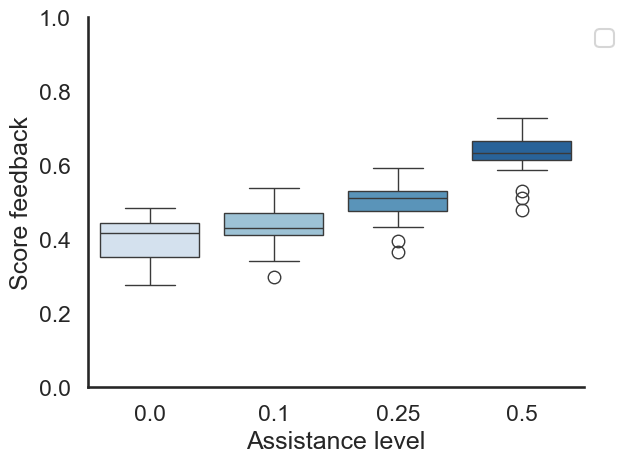

In [100]:
# Score feedback vs Assistance
plt = sns.boxplot(data=df_assis, x='assistance', y='score_feedback', palette="Blues")
plt.set_xlabel('Assistance level')
plt.set_ylabel('Score feedback')
plt.set(ylim=(0,1))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

## Group by block

In [101]:
# Group by block. One ablock for each subject
df_block = df_grouped.groupby(['SN', 'block']).mean().reset_index()

# Erase block column
df_block = df_block.drop('assistance', axis=1)

# Display the new dataframe
print(df_block)

     SN  block     score  score_feedback   SoA  SoA_normalized
0     1      1  0.221427        0.418753  4.00         0.37500
1     1      2  0.330653        0.507134  4.80         0.47500
2     1      3  0.220882        0.395791  3.80         0.35000
3     1      4  0.184858        0.378319  4.05         0.38125
4     1      5  0.227947        0.406775  2.80         0.22500
..   ..    ...       ...             ...   ...             ...
115  20      2  0.466584        0.585204  7.50         0.62500
116  20      3  0.426446        0.557919  7.35         0.58750
117  20      4  0.324121        0.478555  7.10         0.52500
118  20      5  0.421201        0.550231  6.30         0.32500
119  20      6  0.354948        0.499841  6.45         0.36250

[120 rows x 6 columns]


In [102]:
# statistics on SoA between blocks
pg.anova(data=df_block, dv='block', between='SoA', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,SoA,143.602381,57,2.519340,0.756787,0.855862,0.410293
1,Within,206.397619,62,3.328994,NaN,NaN,NaN


Because is not statiscal significant I can't do the pairwise

### Line trend inserted and p-value of the slope of the line for the following two graphs

Slope (correlation strength): 0.0129
Intercept: 0.2664
R-squared (correlation coefficient squared): 0.0348


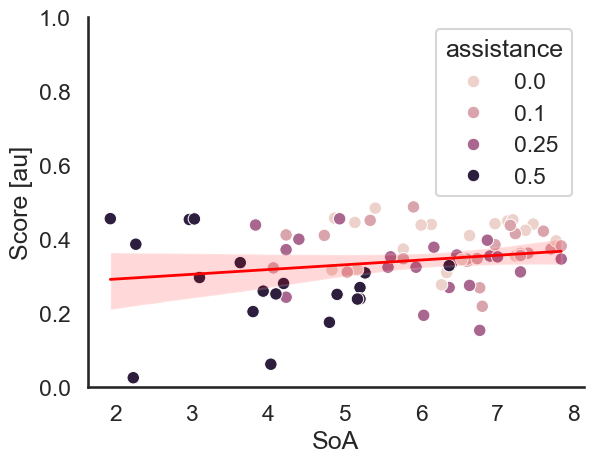

In [103]:
from scipy.stats import linregress

# SoA vs score
plt = sns.scatterplot(data=df_assis, x='SoA', y='score', hue='assistance')

# Add best fit line (without hue)
sns.regplot(data=df_assis, x='SoA', y='score', scatter=False, color='red', line_kws={'linewidth': 2})

plt.set_xlabel('SoA')
plt.set_ylabel('Score [au]')
plt.set(ylim=(0,1))

sns.despine()

# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(df_assis['SoA'], df_assis['score'])

print(f"Slope (correlation strength): {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared (correlation coefficient squared): {r_value**2:.4f}")

Slope (correlation strength): -0.0440
Intercept: 0.7409
R-squared (correlation coefficient squared): 0.3543


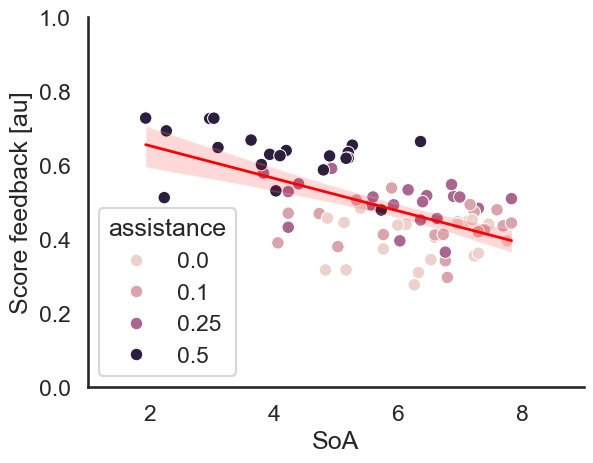

In [104]:
# SoA vs score
plt = sns.scatterplot(data=df_assis, x='SoA', y='score_feedback', hue='assistance')

# Add best fit line (without hue)
sns.regplot(data=df_assis, x='SoA', y='score_feedback', scatter=False, color='red', line_kws={'linewidth': 2})

plt.set_xlabel('SoA')
plt.set_ylabel('Score feedback [au]')
plt.set(ylim=(0,1))
plt.set(xlim=(1,9))

sns.despine()

# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(df_assis['SoA'], df_assis['score_feedback'])

print(f"Slope (correlation strength): {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared (correlation coefficient squared): {r_value**2:.4f}")

## SoA distribution

C:\Users\merin\AppData\Local\Temp\ipykernel_27788\1398392145.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.barplot(data=test2, x='SoA', y='count', palette="mako")


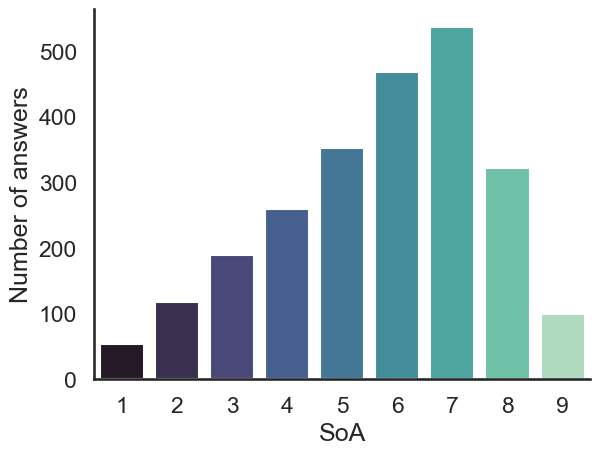

In [105]:
# SoA vs Number of answers
test2 = pd.DataFrame({'count': merged_df.groupby(["SoA"]).size()}).reset_index()

# SoA vs Number of answers
plt = sns.barplot(data=test2, x='SoA', y='count', palette="mako")

plt.set_xlabel('SoA')
plt.set_ylabel('Number of answers')

sns.despine()

In [106]:
test2

,SoA,count
0,1,53
1,2,118
2,3,190
3,4,260
4,5,353
5,6,468
6,7,537
7,8,322
8,9,99
